# Estudio de la evolución de la pandemia por el modelo ARIMA para la isla de El Hierro

En este estudio se analiza la evolución de la pandemia de COVID-19 en la isla de El Hierro y la influencia de factores como los atmosféricas en la evolución de dicha enfermedad. Para este fin se utiliza el modelo ARIMA tanto univariable como multivariable. 

El estudio se fragmenta en 4 partes:
* modelado univariable donde se emplea únicamente la variable objetivo.
* modelado multivariable empleando las variables pandémicas. Dichas variables son:
    * pcr_total: Número total de pruebas PCR realizadas.
    * Urg_cv: Ingresos en el servicio de urgencias por COVID19.
    * HPT_cv19: Ocupación del resto de camas para pacientes COVID.
    * CCR_cv19: Ocupación de las unidades críticas con respirador para pacientes COVID.
* modelado multivariable empleando las variables atmosféricas:
    * tmin: Temperatura mínima diaria.    
    * tmed: Temperatura media diaria.  
    * presMax: Presión máxima al nivel de la estación.   
* modelado multivariable con todas las variables.

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def visualizar_STL(df):
    ''' Visualiza el gráfico STL con la descomposición en tendencia, estacionalidad y residuos de la serie temporal
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''
    stl = STL(df, period=12)
    res = stl.fit()
    
    fig = res.plot()

    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

    plt.xticks(rotation=90)
    plt.show()
    

def visualizar_adf(df):
    ''' Visualiza el p-valor del estudio de Dickey-Fuller para determinar la estacionalidad de los datos
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''

    adf = adfuller(df)
    print("ADF p-value:" + str(adf[1]))
    

def visualizar_acf(df, n_lags):
    ''' Método que visualiza un gráfico con la autocorrelación de los datos con los n rezagos anteriores
    
    Args:
        df (DataFrame): Dataframe con los datos a realizar ele studio de autocorrelación parcial
        n_lags (integer): Número de rezagos a analizar
    '''
    plt.figure(figsize=(16, 10))
    plot_acf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación')
    plt.title('ACF')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.show()
    
def visualizar_pacf(df, n_lags):
    ''' Método que visualiza un gráfico con la autocorrelación parcial de los datos con los n rezagos anteriores
    
    Args:
        df (DataFrame): Dataframe con los datos a realizar ele studio de autocorrelación parcial
        n_lags (integer): Número de rezagos a analizar
    '''
    plt.figure(figsize=(16, 6))
    plot_pacf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación parcial')
    plt.title('PACF')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.show()
    
    
def visualizar_dif_pred_test(test, pred, variable, tit):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
    
    Args:
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
        tit(string): título del gráfico
    '''
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(test.index, test, label='Test', color='green')
    plt.plot(test.index, pred, label='Predicción', color='orange')

    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.xticks(rotation=60)
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, tit, color, dif):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
        y muestra el historico de casos en función del número de días que indiquemos que muestre
    
    Args:
        train (DataFrame): Conjunto de datos de entrenamiento
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable (string): Variable objetivo
        dias_historico (integer): días hacia atrás a mostrar del historico
        tit (string): título del gráfico
        color (string): color de la isla para visualizar
    '''
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color)
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color)
        plt.plot(test.index, test, label='Test', color='green')
    
    plt.plot(test.index, pred, label='Predicción', color='orange')
    plt.bar(test.index, dif, width=0.5, color='black', alpha=0.2, align='edge', label='Diferencia')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(test.index), step=5),   train_s.index.union(test.index)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_bic_aic(modelo):
    ''' Visualiza los datos de BIC (Criterio de Información Bayesiano) y  AIC (Criterio de Información de Akaike)
    
    Args:
        modelo (ARIMA): modelo ARIMA entrenado
    '''
    
    bic = modelo.bic
    aic = modelo.aic

    print("BIC del modelo ARIMA:", bic)
    print("AIC del modelo ARIMA:", aic)
    
def visualizar_resultados_texto(y_test, y_pred, variable):
    ''' Método que visualiza por pantalla en formato de texto el número de csaos reales y los predichos por el algoritmo
    
    Args:
        y_test (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
    '''
    fechas = y_test.index
    for i in range(len(y_test)):
        if variable != '':
            valor_test = y_test[variable][i]
        else:
            valor_test = y_test[i] 
        print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))
        
def obtener_df_diferencias(test, pred, variable):
    ''' Obtiene la diferencia entre los valores de test y los predichos
    
    Args:
        test (Serie): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
    '''
    df_result = test.copy()
    if variable != '':
        df_result = df_result[variable]
        df_result = df_result.to_frame()
    else:
        df_result = df_result.to_frame()
    df_result['pred'] = 0
    df_result['dif'] = 0

    for i in range(len(df_result)):
        df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
        df_result.iloc[i, df_result.columns.get_loc('dif')] = df_result['numero_casos'][i] - pred[i]
        
    return df_result

Inicialmente cargamos los datos del fichero con los datos procesados anteriormente y obtenemos los datos únicamente para la isla de El Hierro.

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos_islas = pd.read_csv('../data/Final/datos_reduc_final.csv', header=0)

# Obtenemos los datos de la isla a la que se le va a realizar el estudio
datos_ElHierro = datos_islas[datos_islas['isla'] == 'EL HIERRO'].copy()


datos_ElHierro = datos_ElHierro.sort_values(by='fecha')   # Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_ElHierro.set_index('fecha', inplace=True)           # Añadimos como índice de los datos la fecha

In [4]:
objetivo = 'numero_casos' # Variable objetivo
n_dias = 10               # Numero de días correspondiente al conjunto de TEST
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train
color_isla = 'purple'     # Color de la isla en las visualizaciones
isla = 'El Hierro'        # Nombre de la isla para las visualizaciones    

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']   # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                         # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables

Separamos los datos en función de las variables a emplear en cada uno de los estudios que se van a realizar.

In [5]:
# Obtenemos los conjuntos de datos para cada modelo con las variables necesarias para cada uno de ellos

datos_ElHierro_arima_uni = datos_ElHierro[objetivo]               # Datos modelo Univariable
datos_ElHierro_arima_mult_covid = datos_ElHierro[[objetivo] + variables_covid] # Datos modelo Multivariable con datos pandémicos
datos_ElHierro_arima_mult_atm = datos_ElHierro[[objetivo] + variables_atm]     # Datos modelo Multivariable con datos atmosféricos
datos_ElHierro_arima_total = datos_ElHierro.copy()                # Datos modelo Multivariable con todos los datos

Descomponemos la serie temporal en sus tres componentes principales: tendencia, estacionalidad y residuos.

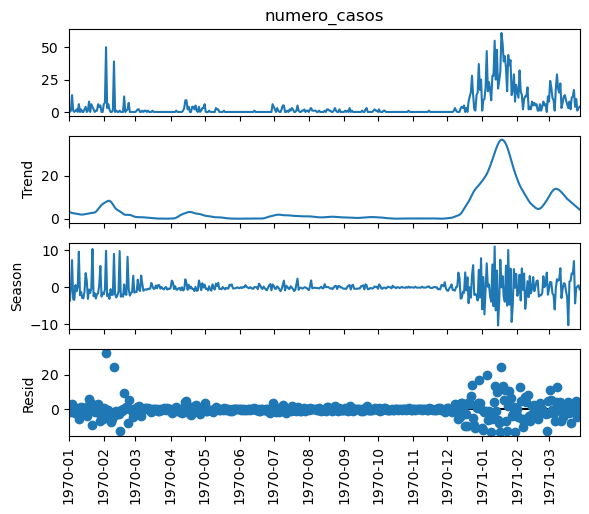

In [6]:
visualizar_STL(datos_ElHierro_arima_uni)

Para aplicar el modelo de ARIMA debemos de investigar los valores óptimos iniciales para los parámetros p,d,q los cuales equivalen a Autorregresivo (AR), Integrado (I), Promedio Móvil (MA). Para obtener el parámetro óptimo realizaremos diferentes estudios: 
* Para el parámetro d realizamos la prueba de Dickey-Fuller para determinar la estacionalidad de los datos de forma que si los datos son no estacionarios debemos de aplicar diferenciaciones hasta obtener una serie temporal, siendo este número de diferenciaciones el valor de d. Si la serie temporal ya era estacionaria el valor será 0.
* Para el parámetro q emplearemos la función de autocorrelación donde se estudia la correlación de los datos de la serie temporal con sus rezagos, de forma que el rezago anterior a que entre en la zona de confianza equivaldrá a nuestro parámetro óptimo.
* Para el parámetro p utilizamos la función de autocorrelación parcial que al igual que el parámetro anterior el rezago anterior a aquel que entre en la zona de confianza será el valor inicial ópti.
io.

En primer lugar realizamos la prueba de Dickey-Fuller para verificar si la serie temporal es estacionaria.

In [7]:
visualizar_adf(datos_ElHierro_arima_uni)

ADF p-value:0.055849165645199116


Realizamos una diferenciación de la serie temporal y realizamos de nuevo la prueba de Dickey-Fuller.

In [8]:
datos_ElHierro_arima_uni_1d = datos_ElHierro_arima_uni.diff().dropna()
visualizar_adf(datos_ElHierro_arima_uni_1d)

ADF p-value:1.2381611212624567e-07


Para la isla de El Hierro es necesaria una diferenciación para poder obtener una serie temporal estacionaria por lo que el parámetro d es 1.

Una vez ajustado el parámetro d realizamos un análisis de la Función de autocorrelación (ACF) para medir la correlación de la serie temporal y sus valores rezagados para determinar el valor de q.

<Figure size 1600x1000 with 0 Axes>

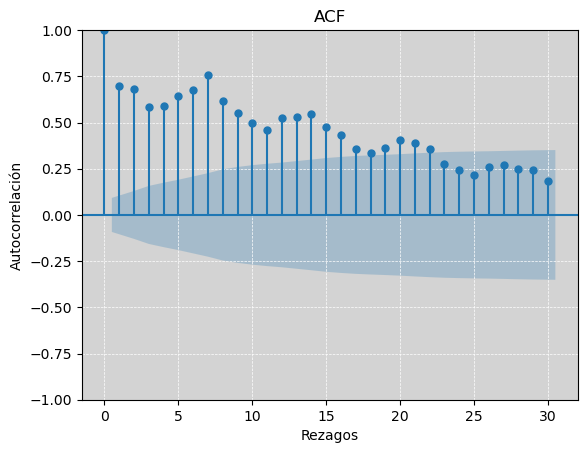

In [9]:
visualizar_acf(datos_ElHierro_arima_uni, 30)

Por último realizamos un análisis de la Función e Autocorrelación Parcial (PACF) para determinar el valor de p.

<Figure size 1600x600 with 0 Axes>

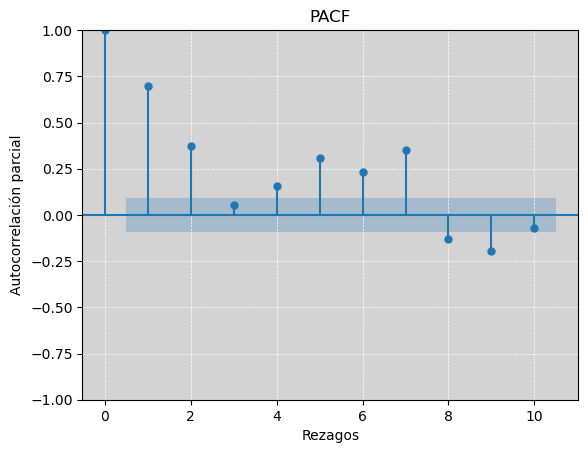

In [10]:
visualizar_pacf(datos_ElHierro_arima_uni, 10)

In [11]:
# Parámetros del modelo ARIMA
p = 3   # Parámetro Autorregresivo (AR)
d = 1   # Parámetro Integrado (I)
q = 3   # Parámetro Promedio Movil (MA)

# Modelo ARIMA univariable

Realizamos el análisis con los datos únicamente de la variable objetivo obteniendo un modelo ARIMA univariable.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [12]:
# Conjuntos de entrenamiento y test
train = datos_ElHierro_arima_uni.iloc[:len(datos_ElHierro_arima_uni) - n_dias]
test =  datos_ElHierro_arima_uni.iloc[len(datos_ElHierro_arima_uni) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [13]:
arima_ElHierro = ARIMA(endog=train, order=(p, d, q), freq = 'D')
modelo_arima_ElHierro = arima_ElHierro.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Como medida de validación del modelo visualizamos los resuldatos del criterio de información Bayesiano (BIC) y el criterio de información Akaike(AIC).

In [14]:
visualizar_bic_aic(modelo_arima_ElHierro)

BIC del modelo ARIMA: 2776.04141619002
AIC del modelo ARIMA: 2747.418102061892


Evaluamos los residuos del modelo mediante la función de autocorrelación para determinar la correlación entre los residuos, si existe una fuerte correlación entre ellos implicaría que el modelo no está bien ajustado.

<Figure size 1600x1000 with 0 Axes>

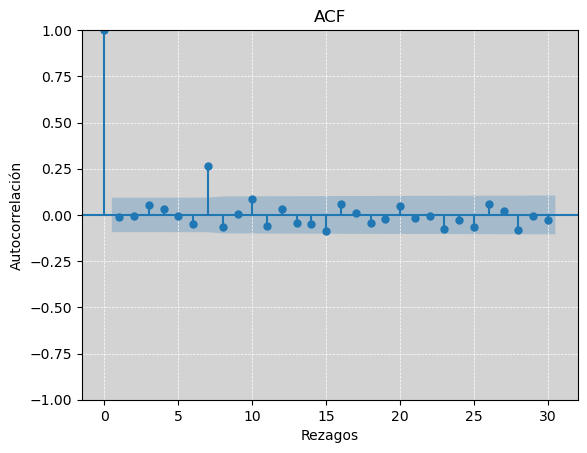

In [15]:
visualizar_acf(modelo_arima_ElHierro.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [16]:
pred = modelo_arima_ElHierro.forecast(steps=n_dias)
#pred = model_arima_tenerife.predict(start=test.index[0], end=test.index[-1])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [17]:
visualizar_resultados_texto(test, pred, '')

2022-03-19: número de casos reales 8, número de casos predichos 3.1146910497053866
2022-03-20: número de casos reales 2, número de casos predichos 3.567003607309084
2022-03-21: número de casos reales 11, número de casos predichos 6.023141518681994
2022-03-22: número de casos reales 12, número de casos predichos 7.786184874220162
2022-03-23: número de casos reales 17, número de casos predichos 7.97774249351614
2022-03-24: número de casos reales 4, número de casos predichos 6.456056459200992
2022-03-25: número de casos reales 10, número de casos predichos 4.482531035398484
2022-03-26: número de casos reales 1, número de casos predichos 3.471478849215049
2022-03-27: número de casos reales 3, número de casos predichos 4.073892818320145
2022-03-28: número de casos reales 4, número de casos predichos 5.735257859326526


Graficamos la diferencia entre los valores de test y los predichos.

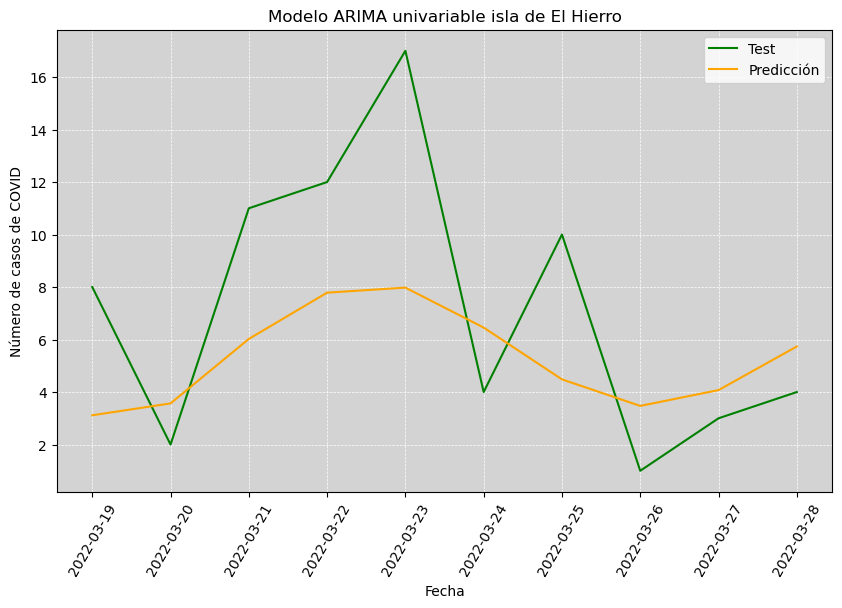

In [18]:
# Título para las visualizaciones
tit = 'Modelo ARIMA univariable isla de ' + isla
visualizar_dif_pred_test(test, pred, '', tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [19]:
df_result = obtener_df_diferencias(test, pred, '')
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,8,3.114691,4.885309
2022-03-20,2,3.567004,-1.567004
2022-03-21,11,6.023142,4.976858
2022-03-22,12,7.786185,4.213815
2022-03-23,17,7.977742,9.022258
2022-03-24,4,6.456056,-2.456056
2022-03-25,10,4.482531,5.517469
2022-03-26,1,3.471479,-2.471479
2022-03-27,3,4.073893,-1.073893


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

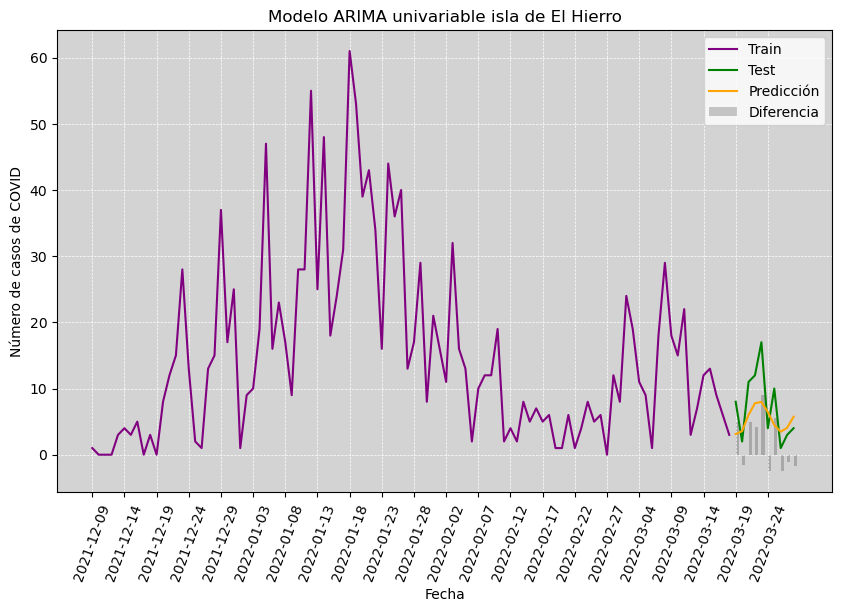

In [20]:
visualizar_historico(train, test, pred, '', n_dias_train_vis, tit, color_isla, df_result['dif'])

Para la evaluación del modelo se utilizarán las siguientes estimadores:
* MAE: Error absoluto medio
* MSE: Error cuadrático medio 
* RMSE: Raíz del error cuadrático medio 

In [21]:
mae, mse, rmse = obtener_errores(test, pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 19.69954830476059
Error absoluto medio (MAE) del modelo: 3.791939862184963
Raíz del error cuadrático medio (RMSE) del modelo: 4.4384173198067565


# Modelo ARIMA multivariable con variables de pandemia

Realizamos el análisis con los datos pandémicos obteniendo un modelo ARIMA multivariable en base a dichas variables.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [22]:
train = datos_ElHierro_arima_mult_covid.iloc[:len(datos_ElHierro_arima_mult_covid) - n_dias]
test =  datos_ElHierro_arima_mult_covid.iloc[len(datos_ElHierro_arima_mult_covid) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [23]:
arima_ElHierro = ARIMA(endog=train[objetivo],exog=train[variables_covid], order=(p, d, q), freq = 'D')
modelo_arima_ElHierro = arima_ElHierro.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Visualizamos los resultados de los criterios BIC y AIC.

In [24]:
visualizar_bic_aic(modelo_arima_ElHierro)

BIC del modelo ARIMA: 2737.527800557527
AIC del modelo ARIMA: 2692.5483069276115


Evaluamos los residuos del modelo con la función de autocorrelación.

<Figure size 1600x1000 with 0 Axes>

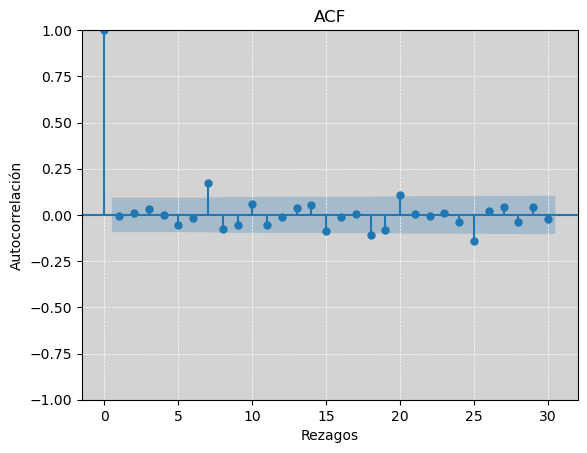

In [25]:
visualizar_acf(modelo_arima_ElHierro.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [26]:
pred = modelo_arima_ElHierro.forecast(steps=n_dias, exog=test[variables_covid])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [27]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 8, número de casos predichos 4.991381796118661
2022-03-20: número de casos reales 2, número de casos predichos 2.9196426428631748
2022-03-21: número de casos reales 11, número de casos predichos 5.8756465213055815
2022-03-22: número de casos reales 12, número de casos predichos 5.332875492200267
2022-03-23: número de casos reales 17, número de casos predichos 7.875609262202175
2022-03-24: número de casos reales 4, número de casos predichos 3.006251541252312
2022-03-25: número de casos reales 10, número de casos predichos 4.020540631495402
2022-03-26: número de casos reales 1, número de casos predichos 2.351873319641627
2022-03-27: número de casos reales 3, número de casos predichos 2.932687857009933
2022-03-28: número de casos reales 4, número de casos predichos 2.571056028072078


Graficamos la diferencia entre los valores de test y los predichos.

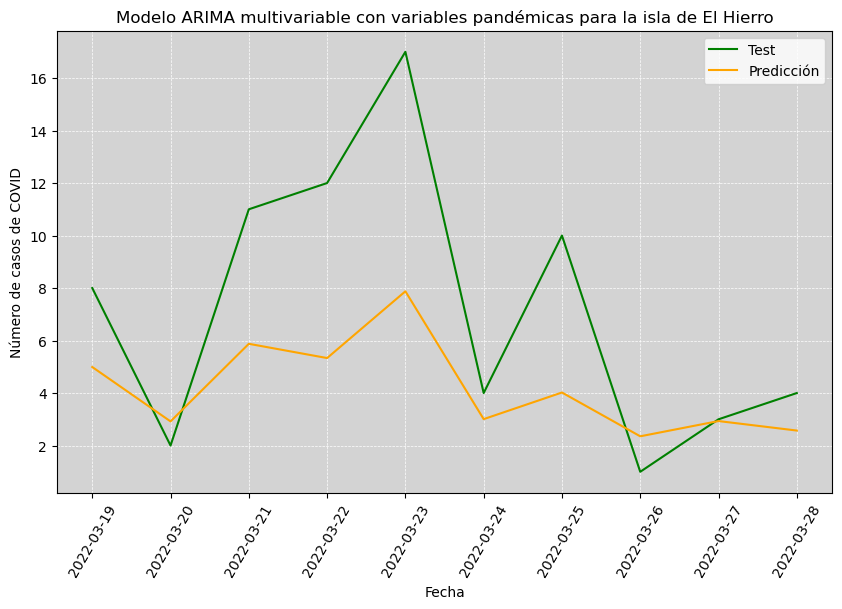

In [28]:
tit = 'Modelo ARIMA multivariable con variables pandémicas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [29]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,8,4.991382,3.008618
2022-03-20,2,2.919643,-0.919643
2022-03-21,11,5.875647,5.124353
2022-03-22,12,5.332875,6.667125
2022-03-23,17,7.875609,9.124391
2022-03-24,4,3.006252,0.993748
2022-03-25,10,4.020541,5.979459
2022-03-26,1,2.351873,-1.351873
2022-03-27,3,2.932688,0.067312


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

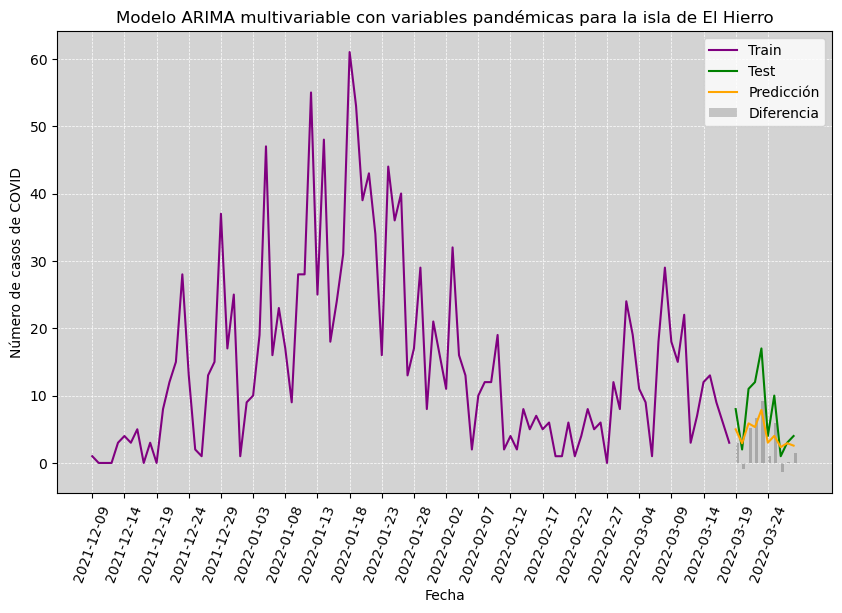

In [30]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

Evaluamos los resultados con las métricas comentadas anteriormente.

In [31]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 20.447702381114343
Error absoluto medio (MAE) del modelo: 3.4665466832848395
Raíz del error cuadrático medio (RMSE) del modelo: 4.521913575148727


# Modelo ARIMA multivariable con variables atmosféricas

Realizamos el análisis con los datos atmosféricos obteniendo un modelo ARIMA multivariable en base a dichas variables.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [32]:
train = datos_ElHierro_arima_mult_atm.iloc[:len(datos_ElHierro_arima_mult_atm) - n_dias]
test =  datos_ElHierro_arima_mult_atm.iloc[len(datos_ElHierro_arima_mult_atm) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [33]:
arima_ElHierro = ARIMA(endog=train[objetivo],exog=train[variables_atm], order=(p, d, q), freq = 'D')
modelo_arima_ElHierro = arima_ElHierro.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Visualizamos los resultados de los criterios BIC y AIC.

In [34]:
visualizar_bic_aic(modelo_arima_ElHierro)

BIC del modelo ARIMA: 2791.8009470798875
AIC del modelo ARIMA: 2750.910498325419


Evaluamos los residuos del modelo con la función de autocorrelación.

<Figure size 1600x1000 with 0 Axes>

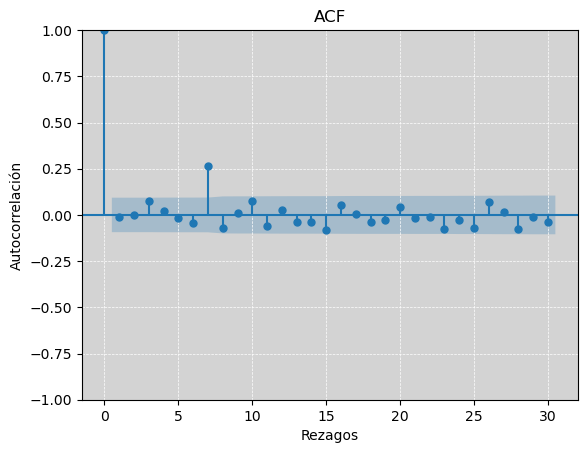

In [35]:
visualizar_acf(modelo_arima_ElHierro.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [36]:
pred = modelo_arima_ElHierro.forecast(steps=n_dias, exog=test[variables_atm])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [37]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 8, número de casos predichos 3.6111779346230897
2022-03-20: número de casos reales 2, número de casos predichos 3.66928898617493
2022-03-21: número de casos reales 11, número de casos predichos 6.226531986355983
2022-03-22: número de casos reales 12, número de casos predichos 7.858836240954194
2022-03-23: número de casos reales 17, número de casos predichos 7.819659639206073
2022-03-24: número de casos reales 4, número de casos predichos 6.259506711457515
2022-03-25: número de casos reales 10, número de casos predichos 4.606711017475536
2022-03-26: número de casos reales 1, número de casos predichos 4.098990753300772
2022-03-27: número de casos reales 3, número de casos predichos 4.487782601076464
2022-03-28: número de casos reales 4, número de casos predichos 6.114471926027171


Graficamos la diferencia entre los valores de test y los predichos.

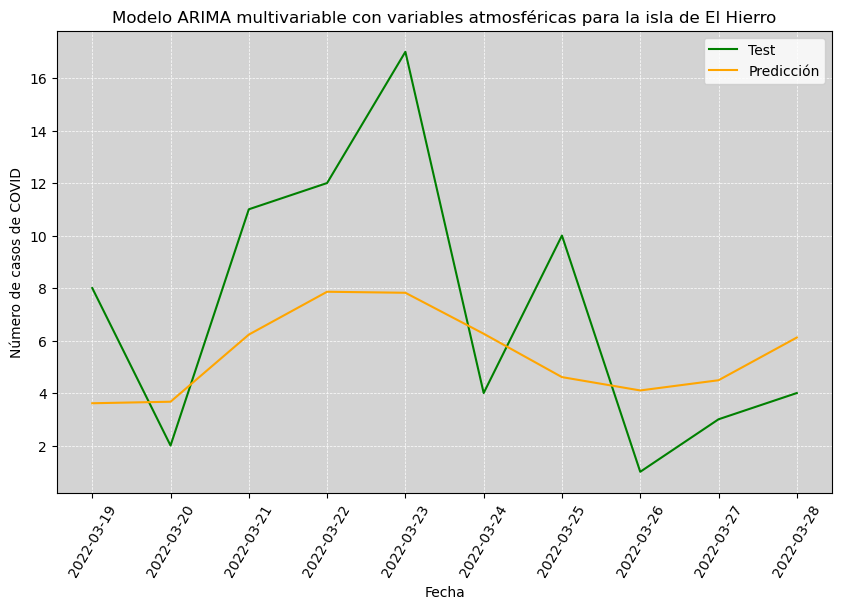

In [38]:
tit = 'Modelo ARIMA multivariable con variables atmosféricas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [39]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,8,3.611178,4.388822
2022-03-20,2,3.669289,-1.669289
2022-03-21,11,6.226532,4.773468
2022-03-22,12,7.858836,4.141164
2022-03-23,17,7.819660,9.180340
2022-03-24,4,6.259507,-2.259507
2022-03-25,10,4.606711,5.393289
2022-03-26,1,4.098991,-3.098991
2022-03-27,3,4.487783,-1.487783


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

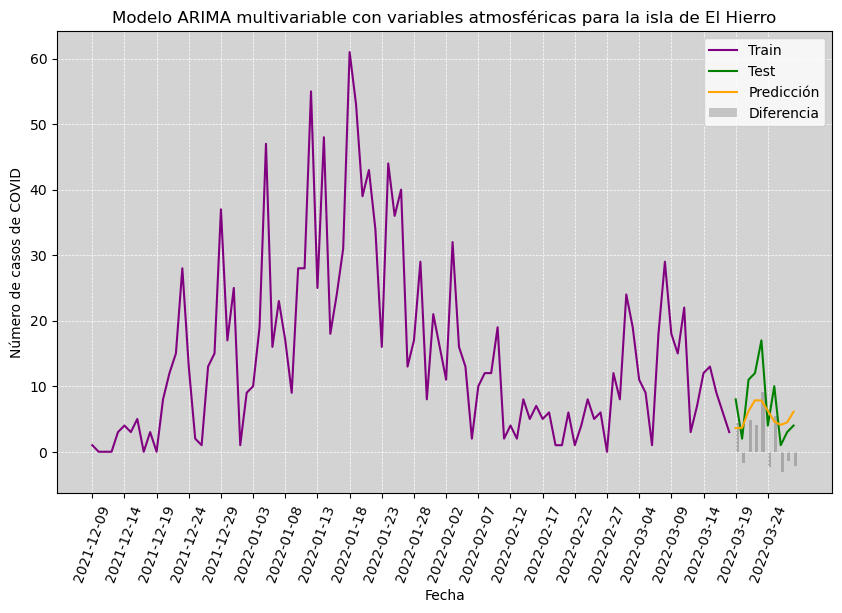

In [40]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

Evaluamos los resultados con las métricas comentadas anteriormente.

In [41]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 19.674333704865102
Error absoluto medio (MAE) del modelo: 3.850712415942197
Raíz del error cuadrático medio (RMSE) del modelo: 4.435575915804519


# Modelo ARIMA multivariable con todas las variables

Realizamos el análisis unificando los datos tanto pandémicos como atmosféricos.

Dividimos los datos en conjunto de entrenamiento y test. Para el conjunto de datos de test se emplean los últimos 10 días de la serie temporal y para el conjunto de entrenamiento el resto de datos.

In [42]:
train = datos_ElHierro_arima_total.iloc[:len(datos_ElHierro_arima_total) - n_dias]
test =  datos_ElHierro_arima_total.iloc[len(datos_ElHierro_arima_total) - n_dias:]

Entrenamos el modelo con los parámetros óptimos obtenidos.

In [43]:
arima_ElHierro = ARIMA(endog=train[objetivo],exog=train[variables], order=(p, d, q), freq = 'D')
modelo_arima_ElHierro = arima_ElHierro.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Visualizamos los resultados de los criterios BIC y AIC.

In [44]:
visualizar_bic_aic(modelo_arima_ElHierro)

BIC del modelo ARIMA: 2753.139906037088
AIC del modelo ARIMA: 2695.8932777808322


Evaluamos los residuos del modelo con la función de autocorrelación.

<Figure size 1600x1000 with 0 Axes>

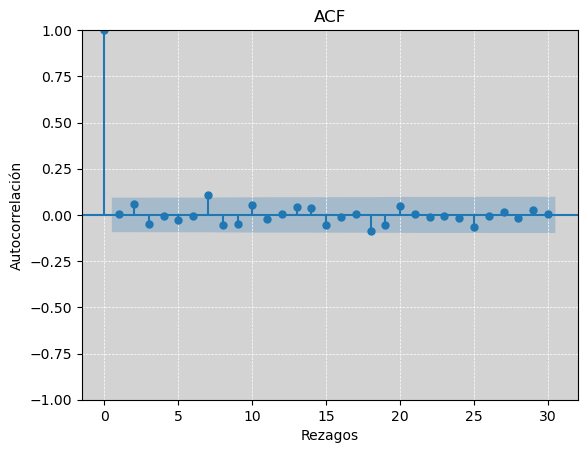

In [45]:
visualizar_acf(modelo_arima_ElHierro.resid, 30)

Realizamos la predicción de las 10 últimas fechas de la serie temporal.

In [46]:
pred = modelo_arima_ElHierro.forecast(steps=10, exog=test[variables])

Visualizamos una comparación entre los valores reales y los valores predichos.

In [47]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 8, número de casos predichos 4.69003835544936
2022-03-20: número de casos reales 2, número de casos predichos 2.622250516696468
2022-03-21: número de casos reales 11, número de casos predichos 5.8953498210119335
2022-03-22: número de casos reales 12, número de casos predichos 5.531399117227764
2022-03-23: número de casos reales 17, número de casos predichos 7.756779073650861
2022-03-24: número de casos reales 4, número de casos predichos 2.854096970089415
2022-03-25: número de casos reales 10, número de casos predichos 3.7579904270444615
2022-03-26: número de casos reales 1, número de casos predichos 2.2077973671558766
2022-03-27: número de casos reales 3, número de casos predichos 2.2472071513905547
2022-03-28: número de casos reales 4, número de casos predichos 2.220648889056747


Graficamos la diferencia entre los valores de test y los predichos.

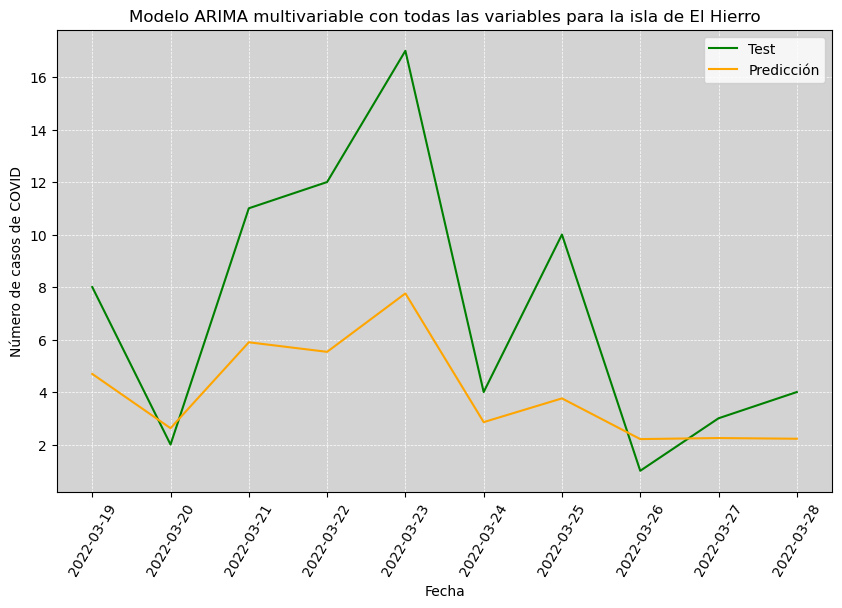

In [48]:
tit = 'Modelo ARIMA multivariable con todas las variables para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

Calculamos la diferencia entre los valores reales y los valores predichos.

In [49]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,8,4.690038,3.309962
2022-03-20,2,2.622251,-0.622251
2022-03-21,11,5.895350,5.104650
2022-03-22,12,5.531399,6.468601
2022-03-23,17,7.756779,9.243221
2022-03-24,4,2.854097,1.145903
2022-03-25,10,3.757990,6.242010
2022-03-26,1,2.207797,-1.207797
2022-03-27,3,2.247207,0.752793


Por último, graficamos una parte del histórico de los datos de entrenamiento junto con los resultados del modelo ARIMA y los valores predichos. A su vez mostramos un histograma con la diferencia entre dichos valores.

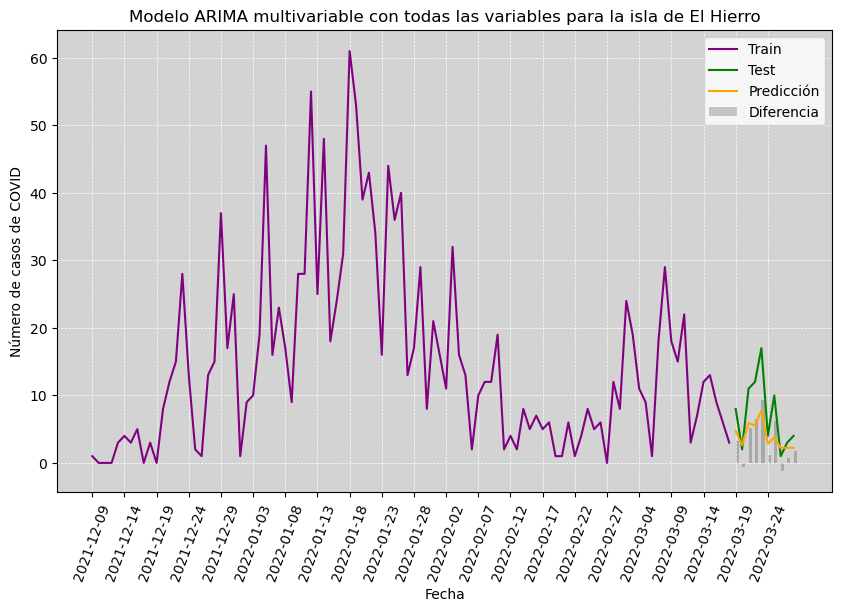

In [50]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

Evaluamos los resultados con las métricas comentadas anteriormente.

In [51]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 21.01477649095367
Error absoluto medio (MAE) del modelo: 3.587653807893125
Raíz del error cuadrático medio (RMSE) del modelo: 4.5841876587846695
